#**Tutorial:** Ensembled Deep Learning for the Classification of Human Sperm Head Morphology - 3x 5-fold CV w/ SCIAN

This notebook will fit all models associated with the 3x 5-fold CV process using the SCIAN dataset for given hyperparameters.

Many functions/classes are used to steamline the code.

The base-model fitting section can be stopped at any point and will resume from that point when restarted.

## ***Setting up***

In [1]:
# Importing libraries

import torch # PyTorch
import torch.nn as nn # For convenience when defining a model
import torchvision # To access pre-trained deep learning models
import torchvision.transforms as transforms # For applying pre-processing and data augmentation to the image data
from torchvision.datasets import ImageFolder # For defining the storage location of image data
from torch.utils.data import TensorDataset # PyTorch uses datasets comprised of tensors
from torch.utils.data.dataloader import DataLoader # For loading mini-batches during training process
from torch.utils.data import random_split, Dataset, Subset, WeightedRandomSampler # For generating a random split between the training and testing data,
#   For creating a dataset object (I think), For taking a subset of a dataset.


import numpy as np # For manipulating arrays and other python object types. 'np' is standard shorthand.
import pandas as pd # For manipulating dataframes. 'pd' is standard shorthand.
from collections import Counter # To count images in each class
import matplotlib.pyplot as plt
import math # Some basic mathematic functions
import warnings # For checking this a working as expected
import sklearn
import sklearn.metrics # For easy calculation of performance metrics
import csv
import os
from pathlib import Path

##***Functions***

In [2]:
def foldSizes(dataset, k):
  """
  Takes the dataset and the number of desired folds and determines the number of examples in each fold
  """
  fold_base_size = math.floor(len(dataset)/k) # the minimum size of a fold.
  fold_sizes = [fold_base_size]*5 # a list containing the sizes of each fold
  # Calculating the un-allocated images
  remaining_count = len(dataset) % k
  # Distributing the un-allocated images across the folds
  for i in range(remaining_count):
    fold_sizes[i] += 1

  # Checking all images are allocated
  if sum(fold_sizes) != len(dataset):
    warnings.warn("Not all iamges are allocated to folds")

  return fold_sizes

In [3]:
def allFoldsTrainTestIndices(seed, dataset, fold_sizes):
  """
  Outputs a list containing the train and test set indices for each of the k-folds, given a random seed.
  This can be used for completing the 1x 5-fold CV in parts rather than all at once.
  """
  # Set seed for random split
  torch.manual_seed(seed)

  # Create the indices for each fold
  folds = torch.utils.data.random_split(dataset, fold_sizes)
  # Extracting indices
  fold_indices = []
  for fold in folds:
    fold_indices.append(fold.indices)

  # Creating train and test sets (ie. combining indices) for each fold

  train_test_idx_folds = [] # Storage containing train and test indices for all folds

  for fold in range(len(fold_sizes)): # len(fold_sizes) is effectively 'k'
    train_idx = [] # Storage
    test_idx = []  # Storage
    train_test_idx_fold = [] # Storage for both the above lists

    # Using respective folds to create train and test sets
    for i in range(k):
      if i == fold:
        test_idx = fold_indices[i]
      else:
        train_idx = train_idx + fold_indices[i]

      # Checking that there is no overlap
    if len(set(train_idx).intersection(test_idx)): # If there is any overlap between the training and testing sets
      warnings.warn("Train and test set images are not mutually exclusive")

    # Making a list of lists containing train indicies and test indices
    train_test_idx_fold.append(train_idx)
    train_test_idx_fold.append(test_idx)

    # Append train and test indices for this fold to a list containing this for all folds
    train_test_idx_folds.append(train_test_idx_fold)
  return train_test_idx_folds

In [4]:
def trainBaseModel(model, num_epochs, learn_rate, dl_train, dl_test,
                   patience=10, min_delta=1e-4, model_save_path='./model.pth'):
  """
  Training loop with early stopping based on F1-score.
  NOTE: Early stopping is performed on test data (not ideal).
  Modified to work with local filesystem.
  """

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  best_f1 = 0
  best_acc = 0
  best_re = 0
  best_pr = 0
  best_epoch = 0

  f1_scores = []
  epochs_no_improve = 0

  optimizer = torch.optim.Adam(params=model.parameters(), lr=learn_rate)
  criterion = nn.CrossEntropyLoss()

  for epoch in range(num_epochs):

    # -----------------------
    # TRAIN
    # -----------------------
    model.train()
    for images, labels in dl_train:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # -----------------------
    # EVALUATE
    # -----------------------
    model.eval()
    test_preds = []
    test_labels = []

    with torch.no_grad():
      for images, labels in dl_test:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_preds += predicted.tolist()
        test_labels += labels.tolist()

    test_preds = torch.tensor(test_preds).cpu()
    test_labels = torch.tensor(test_labels).cpu()

    accuracy = sklearn.metrics.accuracy_score(test_labels, test_preds)
    recall = sklearn.metrics.recall_score(test_labels, test_preds, average="macro")
    precision = sklearn.metrics.precision_score(test_labels, test_preds, average="macro")
    f1_score = sklearn.metrics.f1_score(test_labels, test_preds, average="macro")

    f1_scores.append(f1_score)

    # -----------------------
    # EARLY STOPPING CHECK
    # -----------------------
    if f1_score > best_f1 + min_delta:
      best_f1 = f1_score
      best_acc = accuracy
      best_re = recall
      best_pr = precision
      best_epoch = epoch
      epochs_no_improve = 0

      torch.save(model, model_save_path)

    else:
      epochs_no_improve += 1

    if epoch % 10 == 0:
      print(f"Epoch [{epoch+1}/{num_epochs}] | F1: {f1_score:.4f}")

    if epochs_no_improve >= patience:
      print(f"Early stopping triggered at epoch {epoch+1}")
      break

  # -----------------------
  # RESULTS
  # -----------------------
  print('Results:\n \
  Accuracy  = {:.3f}% \n \
  Recall    = {:.3f}% \n \
  Precision = {:.3f}% \n \
  F1 Score  = {:.3f}% \n \
  Best Epoch = {}'.format(
      best_acc, best_re, best_pr, best_f1, best_epoch + 1
  ))

  plt.plot(f1_scores)
  plt.xlabel("Epoch")
  plt.ylabel("F1-score")
  plt.show()

  return best_acc, best_re, best_pr, best_f1

In [5]:
def trainMetaClassifier(model, num_epochs, learn_rate, momentum, weight_decay,
                        dl_train, dl_test, patience=10, min_delta=1e-4, model_save_path='./model.pth'):
  """
  Training loop for the Meta-Classifier with early stopping.
  NOTE: Early stopping is performed on test data (not ideal).
  Modified to work with local filesystem.
  """

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  best_f1 = 0
  best_acc = 0
  best_re = 0
  best_pr = 0
  best_epoch = 0

  epochs_no_improve = 0

  optimizer = torch.optim.SGD(
      params=model.parameters(),
      lr=learn_rate,
      momentum=momentum,
      weight_decay=weight_decay
  )

  criterion = nn.CrossEntropyLoss()

  for epoch in range(num_epochs):

    # -----------------------
    # TRAIN
    # -----------------------
    model.train()
    for inputs, labels in dl_train:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # -----------------------
    # EVALUATE
    # -----------------------
    model.eval()
    test_preds = []
    test_labels = []

    with torch.no_grad():
      for inputs, labels in dl_test:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_preds += predicted.tolist()
        test_labels += labels.tolist()

    test_preds = torch.tensor(test_preds).cpu()
    test_labels = torch.tensor(test_labels).cpu()

    accuracy = sklearn.metrics.accuracy_score(test_labels, test_preds)
    recall = sklearn.metrics.recall_score(test_labels, test_preds, average="macro")
    precision = sklearn.metrics.precision_score(test_labels, test_preds, average="macro")
    f1_score = sklearn.metrics.f1_score(test_labels, test_preds, average="macro")

    # -----------------------
    # EARLY STOPPING CHECK
    # -----------------------
    if f1_score > best_f1 + min_delta:
      best_f1 = f1_score
      best_acc = accuracy
      best_re = recall
      best_pr = precision
      best_epoch = epoch
      epochs_no_improve = 0

      torch.save(model, model_save_path)

    else:
      epochs_no_improve += 1

    if epoch % 10 == 0:
      print(f"Epoch [{epoch+1}/{num_epochs}] | F1: {f1_score:.4f}")

    if epochs_no_improve >= patience:
      print(f"Early stopping triggered at epoch {epoch+1}")
      break

  # -----------------------
  # RESULTS
  # -----------------------
  print('Results:\n \
  Accuracy  = {:.3f}% \n \
  Recall    = {:.3f}% \n \
  Precision = {:.3f}% \n \
  F1 Score  = {:.3f}% \n \
  Best Epoch = {}'.format(
      best_acc, best_re, best_pr, best_f1, best_epoch + 1
  ))

  return best_acc, best_re, best_pr, best_f1

In [6]:
  # Softmax function
  def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [7]:
# Generate predictions using the trained model
def generateCNNPredictions(data_path, transformations, train_test_idx, batch_size, seed, device='cuda:0', model_save_path='./model.pth'):
  """
  This function produces predictions for a single fold using the trained model saved to the temporary location.
  These will form part of the train and test sets for the meta-classifier.
  Modified for 2 classes.
  """

  # Load the data with test set transformations applied (ie. no data augmentation)
  dataset = ImageFolder(data_path, transform=transformations)
  train_test_idx[0].sort() # Sorting in place, not required.
  train_test_idx[1].sort() # ^
  ds_train = Subset(dataset, indices=train_test_idx[0])
  ds_test = Subset(dataset, indices=train_test_idx[1])

  # We need to redefine the train set sampler to ensure all base-models predict on the data in the same order
  labels_train = [dataset.targets[i] for i in train_test_idx[0]]
  counts = dict(Counter(labels_train))
  counts = np.array(list(counts.values())) # converting counts to a numpy array
  # Assigning a sampling weight to each class
  weights = 1. / counts
  # Getting weights for each image (ie. weight for the class that each image belongs to)
  samples_weight = np.array([weights[t] for t in labels_train])
  samples_weight = torch.from_numpy(samples_weight) # Converting to a tensor
  samples_weight = samples_weight.double() # Converting elements to doubles for some reason
  # Defining the sampler
  g = torch.Generator()
  g.manual_seed(seed)
  sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True, generator=g)
  # Now defining the dataloaders
  dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=False, sampler=sampler)
  dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)
  # Loading the model from save
  model = torch.load(model_save_path, weights_only=False)
  # Sending to device for faster computing
  model.to(device)

  # Generating predictions

  # Train set
  # Storage
  preds_train = []
  labels_train = []
  model.eval() # Set model to evaluation mode, we aren't training so we want the best predictions possible
  with torch.no_grad(): # As we aren't performing backprop, we don't need gradients
    for i, (images, labels) in enumerate(dl_train):
      images = images.to(device)
      labels = labels.to(device)
      preds = model(images)
      preds_train = preds_train + preds.tolist()
      labels_train = labels_train + labels.tolist()

  # Test set
  # Storage
  preds_test = []
  labels_test = []
  model.eval() # Set model to evaluation mode, we aren't training so we want the best predictions possible
  with torch.no_grad(): # As we aren't performing backprop, we don't need gradients
    for i, (images, labels) in enumerate(dl_test):
      images = images.to(device)
      labels = labels.to(device)
      preds = model(images)
      preds_test = preds_test + preds.tolist()
      labels_test = labels_test + labels.tolist()

  # Converting to softmax
  # Train
  for i in range(len(preds_train)):
    preds_train[i] = softmax(preds_train[i])
  # Test
  for i in range(len(preds_test)):
    preds_test[i] = softmax(preds_test[i])

  # Convert to dataframes for easier saving - Modified for 2 classes
  df_train = pd.merge(pd.DataFrame(labels_train), pd.DataFrame(preds_train), left_index=True, right_index=True)
  df_test = pd.merge(pd.DataFrame(labels_test), pd.DataFrame(preds_test), left_index=True, right_index=True)
  # Adjusting column names - Modified for 2 classes
  col_names = ['labels', '0', '1']
  df_train.columns = col_names
  df_test.columns = col_names

  return df_train, df_test

In [8]:
def generateMCPredictions(dl_train, dl_test, batch_size, device='cuda:0', model_save_path='./model.pth'):
  """
  Generates predictions using the trained and temporarily saved meta-classifier.
  Modified for 2 classes.
  """
    # Loading the model from save
  model = torch.load(model_save_path, weights_only=False)
  # Sending to device for faster computing
  model.to(device)

  # Generating predictions
  #
  # Train set
  # Storage
  preds_train = []
  labels_train = []
  model.eval() # Set model to evaluation mode, we aren't training so we want the best predictions possible
  with torch.no_grad(): # As we aren't performing backprop, we don't need gradients
    for i, (inputs, targets) in enumerate(dl_train):
      inputs = inputs.to(device)
      targets = targets.to(device)
      preds = model(inputs)
      preds_train = preds_train + preds.tolist()
      labels_train = labels_train + targets.tolist()

  # Test set
  # Storage
  preds_test = []
  labels_test = []
  model.eval() # Set model to evaluation mode, we aren't training so we want the best predictions possible
  with torch.no_grad(): # As we aren't performing backprop, we don't need gradients
    for i, (inputs, targets) in enumerate(dl_test):
      inputs = inputs.to(device)
      targets = targets.to(device)
      preds = model(inputs)
      preds_test = preds_test + preds.tolist()
      labels_test = labels_test + targets.tolist()

  # Converting to softmax
  # Train
  for i in range(len(preds_train)):
    preds_train[i] = softmax(preds_train[i])
  # Test
  for i in range(len(preds_test)):
    preds_test[i] = softmax(preds_test[i])

  # Convert to dataframes for easier saving - Modified for 2 classes
  df_train = pd.merge(pd.DataFrame(labels_train), pd.DataFrame(preds_train), left_index=True, right_index=True)
  df_test = pd.merge(pd.DataFrame(labels_test), pd.DataFrame(preds_test), left_index=True, right_index=True)
  # Adjusting column names - Modified for 2 classes
  col_names = ['labels', '0', '1']
  df_train.columns = col_names
  df_test.columns = col_names

  return df_train, df_test

In [9]:
# Identity class for modifying ResNet-34
#   Setting any layer to this class will effectively remove the layer.
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [10]:
def getModel(model_name):
  """
  Loads and returns a pre-trained CNN
  Modified for 2 classes (abnormal/normal)
  """
  pretrained = True
  num_classes = 2  # Changed from 5 to 2 classes

  if model_name == 'vgg16':
    model = torchvision.models.vgg16(pretrained=pretrained)
    model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes, bias=True)
  elif model_name == 'vgg19':
    model = torchvision.models.vgg19(pretrained=pretrained)
    model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes, bias=True)
  elif model_name == 'resnet':
    model = torchvision.models.resnet34(pretrained=pretrained)
    model.fc = nn.Linear(in_features=256, out_features=num_classes, bias=True)
    model.layer4 = Identity()
  elif model_name == 'densenet':
    model = torchvision.models.densenet161(pretrained=pretrained)
    model.classifier = nn.Linear(in_features=2208, out_features=num_classes, bias=True)

  # Returning the required model
  return model

In [11]:
import os

def save_name_generator(cv_config, base_path='./cv_results'):
    """
    Generates the path to save the generated predictions to.
    Modified for local filesystem
    """
    # cv_config is a dataframe row containing the info for the model fit that was just done
    model_name, repeat, fold, = cv_config['model'], cv_config['repeat'], cv_config['fold']
    
    repeats = ['repeat_0/', 'repeat_1/', 'repeat_2/']
    folds = ['fold_0/', 'fold_1/', 'fold_2/', 'fold_3/', 'fold_4/']
    
    repeat_dir = repeats[repeat]
    fold_dir = folds[fold]
    
    train_path = os.path.join(base_path, repeat_dir, fold_dir, f'{model_name}_train.csv')
    test_path = os.path.join(base_path, repeat_dir, fold_dir, f'{model_name}_test.csv')
    
    os.makedirs(os.path.dirname(train_path), exist_ok=True)
    os.makedirs(os.path.dirname(test_path), exist_ok=True)
    
    return train_path, test_path

In [12]:
def MyDataset(path):
  """
  For preparing meta-classifier input data to use with PyTorch.
  """
  # Load dataframe from CSV file
  df = pd.read_csv(path)
  # Define inputs and outputs
  df_inputs = df.iloc[:,1:] # Select all columns except first (labels col)
  df_targets = df.iloc[:,0] # Select first column
  # Performing a necessary conversion from dataframe object
  inputs = torch.from_numpy(df_inputs.values)
  targets = torch.from_numpy(df_targets.values)
  # Converting to a dataset object
  ds = TensorDataset(inputs.float(), targets)
  # Return the final dataset object we wanted
  return ds

In [13]:
# The meta-classifier class
class metaClassifier(nn.Module):
    def __init__(self):
      super(metaClassifier, self).__init__()
      # Modified for 2 classes: 4 models × 2 class probabilities = 8 inputs
      self.fc1 = nn.Linear(8, 16)  # Changed from 20 to 8 inputs
      self.bn1 = nn.BatchNorm1d(16)  # Changed from 32 to 16
      self.dropout1 = nn.Dropout(0.2)
      self.fc2 = nn.Linear(16, 16)  # Changed from 32 to 16
      self.bn2 = nn.BatchNorm1d(16)  # Changed from 32 to 16
      self.dropout2 = nn.Dropout(0.2)
      self.fc3 = nn.Linear(16, 2)  # Changed from 5 to 2 classes

    def forward(self, x):
      # Here we define how the data will pass through the layers
      x = self.fc1(x)
      x = self.bn1(x)
      x = self.dropout1(x)
      x = self.fc2(x)
      x = self.bn2(x)
      x = self.dropout2(x)
      out = self.fc3(x)
      return out

In [14]:
def getSampler(subset_train):
  """Generates the weighted random sampler using the train subset as input"""
  # Getting train set indices
  # Getting labels after sorting indices so weights are applied correctly
  subset_train.indices.sort()
  labels_train = [subset_train.dataset.targets[i] for i in subset_train.indices]

  # Counting
  counts = dict(Counter(labels_train))
  counts = np.array(list(counts.values())) # converting counts to a numpy array

  # Assigning a sampling weight to each class
  weights = 1. / counts

  # Getting/assigning weights for each image (ie. weight for the class that each image belongs to)
  samples_weight = np.array([weights[t] for t in labels_train])
  samples_weight = torch.from_numpy(samples_weight) # Converting to a tensor
  samples_weight = samples_weight.double() # Convrting elements to doubles for some reason

  # Defining the sampler
  sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
  return sampler

## ***Base-Models***

📂 Dataset Structure:
Loading rotated folders:
  - rotated_abnormal: /home/23giang.ns/ML_Project/virtual_stainning/unstained_stained_OLD_augmented_tuned/full_agreement/rotated_abnormal
  - rotated_normal: /home/23giang.ns/ML_Project/virtual_stainning/unstained_stained_OLD_augmented_tuned/full_agreement/rotated_normal

✅ Loaded full_agreement dataset (rotated versions only):
   Total images: 355
   Classes: ['abnormal', 'normal']
   Class to index: {'abnormal': 0, 'normal': 1}
   rotated_abnormal: 262 images
   rotated_normal: 93 images

📊 5-Fold CV Setup:
   Fold sizes: [71, 71, 71, 71, 71]
   Total runs: 15 (3 repeats × 5 folds)

💾 Results will be saved to: ./cv_results

🚀 STARTING BASE MODEL TRAINING

📦 Training VGG16

--- Repeat 0, Fold 0 ---
Train samples: 284, Test samples: 71


/home/23giang.ns/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/23giang.ns/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100] | F1: 0.4835
Epoch [11/100] | F1: 0.5697
Early stopping triggered at epoch 20
Results:
   Accuracy  = 0.803% 
   Recall    = 0.749% 
   Precision = 0.732% 
   F1 Score  = 0.740% 
   Best Epoch = 10


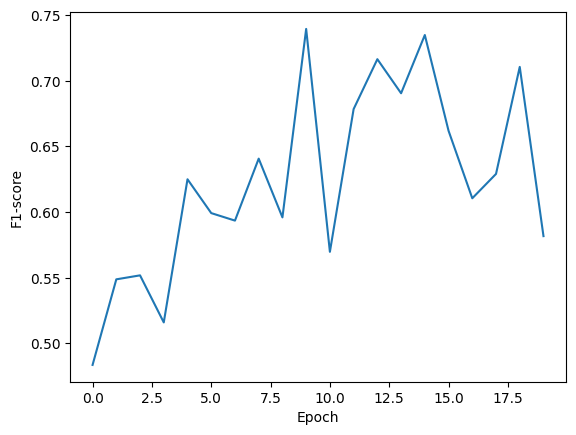

✅ Saved predictions to ./cv_results/repeat_0/fold_0

--- Repeat 0, Fold 1 ---
Train samples: 284, Test samples: 71


/home/23giang.ns/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/23giang.ns/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100] | F1: 0.5159


/home/23giang.ns/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/23giang.ns/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/23giang.ns/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

Epoch [11/100] | F1: 0.6048
Epoch [21/100] | F1: 0.5487
Early stopping triggered at epoch 27
Results:
   Accuracy  = 0.803% 
   Recall    = 0.820% 
   Precision = 0.718% 
   F1 Score  = 0.740% 
   Best Epoch = 17


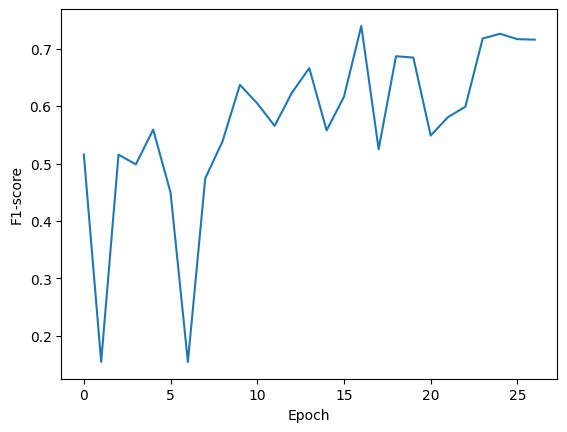

✅ Saved predictions to ./cv_results/repeat_0/fold_1

--- Repeat 0, Fold 2 ---
Train samples: 284, Test samples: 71


/home/23giang.ns/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/23giang.ns/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/23giang.ns/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch [1/100] | F1: 0.4365


/home/23giang.ns/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Epoch [11/100] | F1: 0.6080
Epoch [21/100] | F1: 0.7235
Early stopping triggered at epoch 26
Results:
   Accuracy  = 0.817% 
   Recall    = 0.793% 
   Precision = 0.746% 
   F1 Score  = 0.762% 
   Best Epoch = 16


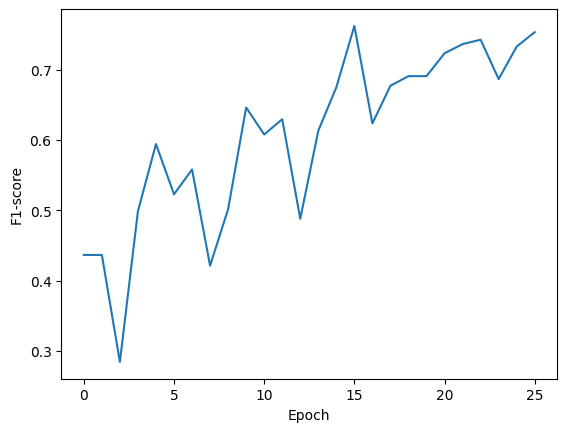

✅ Saved predictions to ./cv_results/repeat_0/fold_2

--- Repeat 0, Fold 3 ---
Train samples: 284, Test samples: 71


/home/23giang.ns/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/23giang.ns/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100] | F1: 0.5450


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from collections import defaultdict
from torch.utils.data import ConcatDataset

# ========================================
# DATA PREPARATION - Modified for LOCAL
# ========================================

# Defining the transformations
transformations_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transformations_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ========================================
# DATASET PATHS - Updated for unstained_stained
# ========================================
# Main stained dataset
data_dir_stained = '/home/23giang.ns/ML_Project/virtual_stainning/unstained_stained_OLD_augmented_tuned'

# Full agreement: high quality labels
data_dir_full = os.path.join(data_dir_stained, 'full_agreement')

# ========================================
# LOADING DATASETS - ONLY rotated_abnormal and rotated_normal folders
# ========================================
# Load rotated versions (augmented data)
data_dir_abnormal = os.path.join(data_dir_full, 'rotated_abnormal')
data_dir_normal = os.path.join(data_dir_full, 'rotated_normal')

print("📂 Dataset Structure:")
print(f"Loading rotated folders:")
print(f"  - rotated_abnormal: {data_dir_abnormal}")
print(f"  - rotated_normal: {data_dir_normal}")

# Create temporary structure for ImageFolder (it expects parent folder with subfolders)
# We'll create a mapping manually
class CustomImageFolder(ImageFolder):
    """Custom ImageFolder that only loads specific folders"""
    def __init__(self, abnormal_path, normal_path, transform=None):
        # Create temporary root with only 2 folders
        import tempfile
        import shutil
        
        self.temp_dir = tempfile.mkdtemp()
        temp_abnormal = os.path.join(self.temp_dir, 'abnormal')
        temp_normal = os.path.join(self.temp_dir, 'normal')
        
        # Create symlinks to original folders
        os.symlink(abnormal_path, temp_abnormal)
        os.symlink(normal_path, temp_normal)
        
        # Initialize with temporary directory
        super().__init__(self.temp_dir, transform=transform)
    
    def __del__(self):
        # Clean up temp directory
        import shutil
        if hasattr(self, 'temp_dir') and os.path.exists(self.temp_dir):
            shutil.rmtree(self.temp_dir)

# Load datasets with rotated folders
dataset_full_train = CustomImageFolder(data_dir_abnormal, data_dir_normal, transform=transformations_train)
dataset_full_test = CustomImageFolder(data_dir_abnormal, data_dir_normal, transform=transformations_test)

print(f"\n✅ Loaded full_agreement dataset (rotated versions only):")
print(f"   Total images: {len(dataset_full_train)}")
print(f"   Classes: {dataset_full_train.classes}")
print(f"   Class to index: {dataset_full_train.class_to_idx}")

# Count images per class
abnormal_count = len([f for f in os.listdir(data_dir_abnormal) if f.endswith('.png')])
normal_count = len([f for f in os.listdir(data_dir_normal) if f.endswith('.png')])
print(f"   rotated_abnormal: {abnormal_count} images")
print(f"   rotated_normal: {normal_count} images")

# ========================================
# K-FOLD CV SETUP
# ========================================
k = 5  # Number of folds for K-fold CV
fold_sizes = foldSizes(dataset_full_train, k)

print(f"\n📊 5-Fold CV Setup:")
print(f"   Fold sizes: {fold_sizes}")

# Getting train-test indices for all folds and repeats
seeds = [42]  # 1 repeat only (changed from 3 repeats)
train_test_idx_all = []

# Generate indices for each seed and store them
for seed in seeds:
    train_test_idx_all = train_test_idx_all + allFoldsTrainTestIndices(seed, dataset_full_train, fold_sizes)

print(f"   Total runs: {len(train_test_idx_all)} (1 repeat × 5 folds)")

# ========================================
# MODEL HYPERPARAMETERS
# ========================================
# [num_epochs, learning_rate, batch_size]
hyperparameters_all = [
    [100, 1e-4, 32],  # vgg16
    [100, 1e-4, 32],  # vgg19
    [100, 1e-4, 32],  # resnet
    [100, 1e-4, 32]   # densenet
]
model_names = ['vgg16', 'vgg19', 'resnet', 'densenet']

# ========================================
# RESULTS STORAGE
# ========================================
base_save_path = './cv_results'
os.makedirs(base_save_path, exist_ok=True)

model_save_path = './model_temp.pth'  # Temporary model save location

# Store path for prediction generation (needs to be the temp directory)
data_dir_for_inference = dataset_full_train.root

print(f"\n💾 Results will be saved to: {base_save_path}")

# ========================================
# TRAINING LOOP - Base Models
# ========================================
print("\n" + "="*70)
print("🚀 STARTING BASE MODEL TRAINING")
print("="*70)

for model_name in model_names:
    print(f"\n{'='*70}")
    print(f"📦 Training {model_name.upper()}")
    print(f"{'='*70}")
    
    metrics = []
    model_hyperparameters = hyperparameters_all[model_names.index(model_name)]
    
    for idx, train_test_idx in enumerate(train_test_idx_all):
        repeat_num = idx // k
        fold_num = idx % k
        
        print(f"\n--- Repeat {repeat_num}, Fold {fold_num} ---")
        
        # Create train/test subsets
        real_train_idx = train_test_idx[0]
        real_test_idx = train_test_idx[1]
        
        ds_train = Subset(dataset_full_train, real_train_idx)
        ds_test = Subset(dataset_full_test, real_test_idx)
        
        # Create dataloaders
        sampler = getSampler(ds_train)
        dl_train = DataLoader(ds_train, batch_size=model_hyperparameters[2], sampler=sampler)
        dl_test = DataLoader(ds_test, batch_size=model_hyperparameters[2], shuffle=False)
        
        print(f"Train samples: {len(ds_train)}, Test samples: {len(ds_test)}")
        
        # Get and train model
        model = getModel(model_name)
        
        best_acc, best_re, best_pr, best_f1 = trainBaseModel(
            model=model,
            num_epochs=model_hyperparameters[0],
            learn_rate=model_hyperparameters[1],
            dl_train=dl_train,
            dl_test=dl_test,
            model_save_path=model_save_path
        )
        
        # Generate predictions - use the temp directory path
        seed = seeds[repeat_num]
        df_preds_train, df_preds_test = generateCNNPredictions(
            data_path=data_dir_for_inference,
            transformations=transformations_test,
            train_test_idx=train_test_idx,
            batch_size=model_hyperparameters[2],
            seed=seed,
            model_save_path=model_save_path
        )
        
        # Save predictions
        cv_config = {"model": model_name, "repeat": repeat_num, "fold": fold_num}
        train_path, test_path = save_name_generator(cv_config, base_path=base_save_path)
        
        df_preds_train.to_csv(train_path, index=False)
        df_preds_test.to_csv(test_path, index=False)
        
        metrics.append((best_acc, best_re, best_pr, best_f1))
        
        print(f"✅ Saved predictions to {os.path.dirname(train_path)}")
    
    # Calculate average metrics
    metrics = np.array(metrics)
    
    mean_acc = metrics[:, 0].mean()
    std_acc = metrics[:, 0].std(ddof=1)
    
    mean_re = metrics[:, 1].mean()
    std_re = metrics[:, 1].std(ddof=1)
    
    mean_pr = metrics[:, 2].mean()
    std_pr = metrics[:, 2].std(ddof=1)
    
    mean_f1 = metrics[:, 3].mean()
    std_f1 = metrics[:, 3].std(ddof=1)
    
    print(f"\n{'='*70}")
    print(f"📊 {model_name.upper()} - AVERAGE RESULTS (1x5-fold CV)")
    print(f"{'='*70}")
    print(f"Accuracy : {mean_acc*100:.2f} ± {std_acc*100:.2f}%")
    print(f"Recall   : {mean_re*100:.2f} ± {std_re*100:.2f}%")
    print(f"Precision: {mean_pr*100:.2f} ± {std_pr*100:.2f}%")
    print(f"F1-score : {mean_f1*100:.2f} ± {std_f1*100:.2f}%")

print("\n" + "="*70)
print("✅ BASE MODEL TRAINING COMPLETED!")
print("="*70)

## ***Meta-Classifier***

In [ ]:
import os
import pandas as pd

# =========================
# Meta-classifier data preparation
# Modified for 2 classes and local paths
# =========================

print("\n" + "="*70)
print("🔧 PREPARING META-CLASSIFIER INPUT DATA")
print("="*70)

# Defining the path variables
repeats = ['repeat_0/', 'repeat_1/', 'repeat_2/']
folds = ['fold_0/', 'fold_1/', 'fold_2/', 'fold_3/', 'fold_4/']
model_names = ['vgg16', 'vgg19', 'resnet', 'densenet']
path_base = './cv_results/'

# Expected column names for final meta-classifier input (2 classes)
# 4 models × 2 class probabilities = 8 features
col_names = (
    ['labels'] +
    [f'vgg16_{i}' for i in range(2)] +
    [f'vgg19_{i}' for i in range(2)] +
    [f'resnet_{i}' for i in range(2)] +
    [f'densenet_{i}' for i in range(2)]
)

# =========================
# Iterating through each CV config
# =========================

for repeat in repeats:
    for fold in folds:

        train_list, test_list = [], []

        # -------------------------
        # Load and rename model predictions
        # -------------------------
        for model_name in model_names:

            train_file = f"{path_base}{repeat}{fold}{model_name}_train.csv"
            test_file = f"{path_base}{repeat}{fold}{model_name}_test.csv"

            if not (os.path.exists(train_file) and os.path.exists(test_file)):
                print(f"⚠️  Warning: Missing files for {model_name} in {repeat}{fold}. Skipping.")
                continue

            df_train = pd.read_csv(train_file)
            df_test = pd.read_csv(test_file)

            # Rename probability columns to avoid collisions
            prob_cols = [c for c in df_train.columns if c != 'labels']

            df_train = df_train.rename(
                columns={c: f"{model_name}_{c}" for c in prob_cols}
            )
            df_test = df_test.rename(
                columns={c: f"{model_name}_{c}" for c in prob_cols}
            )

            train_list.append(df_train)
            test_list.append(df_test)

        # Skip if no data loaded
        if len(train_list) == 0 or len(test_list) == 0:
            print(f"⚠️  Skipping {repeat}{fold} due to missing files.")
            continue

        # -------------------------
        # Merge predictions from different models
        # -------------------------
        mc_train = train_list[0]
        mc_test = test_list[0]

        for i in range(1, len(train_list)):
            mc_train = mc_train.merge(
                train_list[i].drop(columns=['labels']),
                left_index=True,
                right_index=True
            )
            mc_test = mc_test.merge(
                test_list[i].drop(columns=['labels']),
                left_index=True,
                right_index=True
            )

        # -------------------------
        # Final sanity checks
        # -------------------------
        assert mc_train.shape[1] == len(col_names), \
            f"Column mismatch in train: {mc_train.shape[1]} vs {len(col_names)}"
        assert mc_test.shape[1] == len(col_names), \
            f"Column mismatch in test: {mc_test.shape[1]} vs {len(col_names)}"

        # -------------------------
        # Assign final column names
        # -------------------------
        mc_train.columns = col_names
        mc_test.columns = col_names

        # -------------------------
        # Save final meta-classifier inputs
        # -------------------------
        mc_train.to_csv(f"{path_base}{repeat}{fold}mc_train_inputs.csv", index=False)
        mc_test.to_csv(f"{path_base}{repeat}{fold}mc_test_inputs.csv", index=False)

        print(f"✅ Saved meta-classifier inputs for {repeat}{fold}")

print("\n" + "="*70)
print("✅ META-CLASSIFIER DATA PREPARATION COMPLETED!")
print("="*70)

In [ ]:
# Training the meta-classifier

print("\n" + "="*70)
print("🚀 STARTING META-CLASSIFIER TRAINING")
print("="*70)

# Defining path variables
repeats = ['repeat_0/', 'repeat_1/', 'repeat_2/']
folds = ['fold_0/', 'fold_1/', 'fold_2/', 'fold_3/', 'fold_4/']
path_base = './cv_results/'
model_save_path = './model_temp.pth'

# Meta-classifier hyperparameters
num_epochs, learn_rate, batch_size, momentum, weight_decay = 200, 7.801e-2, 47, 0.9855, 5.526e-2

# Training the meta-classifier
for repeat in repeats:
    for fold in folds:
        print(f"\n--- {repeat}{fold} ---")
        
        # Check if input files exist
        train_input_path = path_base + repeat + fold + 'mc_train_inputs.csv'
        test_input_path = path_base + repeat + fold + 'mc_test_inputs.csv'
        
        if not (os.path.exists(train_input_path) and os.path.exists(test_input_path)):
            print(f"⚠️  Skipping {repeat}{fold} - input files not found")
            continue
        
        # Load data and convert to tensor dataset
        ds_train = MyDataset(train_input_path)
        ds_test = MyDataset(test_input_path)
        
        # Define dataloaders
        dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
        dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

        # Define the model
        model = metaClassifier()

        # Training
        best_acc, best_re, best_pr, best_f1 = trainMetaClassifier(
            model=model,
            num_epochs=num_epochs,
            learn_rate=learn_rate,
            momentum=momentum,
            weight_decay=weight_decay,
            dl_train=dl_train,
            dl_test=dl_test,
            model_save_path=model_save_path
        )

        # Generate predictions
        df_preds_train, df_preds_test = generateMCPredictions(
            dl_train=dl_train,
            dl_test=dl_test,
            batch_size=batch_size,
            model_save_path=model_save_path
        )
        
        # Saving predictions
        train_path = path_base + repeat + fold + 'mc_train_outputs.csv'
        test_path = path_base + repeat + fold + 'mc_test_outputs.csv'
        df_preds_train.to_csv(train_path, index=False)
        df_preds_test.to_csv(test_path, index=False)
        
        print(f"✅ Saved predictions to {os.path.dirname(train_path)}")

print("\n" + "="*70)
print("✅ META-CLASSIFIER TRAINING COMPLETED!")
print("="*70)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import pandas as pd

print("\n" + "="*70)
print("📊 EVALUATING META-CLASSIFIER PERFORMANCE")
print("="*70)

all_model_metrics_train = []
all_model_metrics_test  = []

repeats = ['repeat_0/', 'repeat_1/', 'repeat_2/']
folds   = ['fold_0/', 'fold_1/', 'fold_2/', 'fold_3/', 'fold_4/']
path_base = './cv_results/'

for r in repeats:
    for k in folds:
        
        train_output_path = path_base + r + k + 'mc_train_outputs.csv'
        test_output_path = path_base + r + k + 'mc_test_outputs.csv'
        
        if not (os.path.exists(train_output_path) and os.path.exists(test_output_path)):
            print(f"⚠️  Skipping {r}{k} - output files not found")
            continue

        mc_data_train = pd.read_csv(train_output_path)
        mc_data_test  = pd.read_csv(test_output_path)

        y_train = mc_data_train["labels"]
        y_test  = mc_data_test["labels"]

        # Argmax over class probabilities
        y_pred_train = mc_data_train.iloc[:, 1:].idxmax(axis=1).astype(int)
        y_pred_test  = mc_data_test.iloc[:, 1:].idxmax(axis=1).astype(int)

        # Train metrics
        all_model_metrics_train.append([
            f1_score(y_train, y_pred_train, average="macro"),
            recall_score(y_train, y_pred_train, average="macro"),
            precision_score(y_train, y_pred_train, average="macro"),
            accuracy_score(y_train, y_pred_train)
        ])

        # Test metrics
        all_model_metrics_test.append([
            f1_score(y_test, y_pred_test, average="macro"),
            recall_score(y_test, y_pred_test, average="macro"),
            precision_score(y_test, y_pred_test, average="macro"),
            accuracy_score(y_test, y_pred_test)
        ])
        
        print(f"✅ Evaluated {r}{k}")

# Convert to DataFrames
col_names = ['f1-score', 'recall', 'precision', 'accuracy']

df_train = pd.DataFrame(all_model_metrics_train, columns=col_names)
df_test  = pd.DataFrame(all_model_metrics_test,  columns=col_names)

# Mean ± std (sample std)
mean_train = df_train.mean()
std_train  = df_train.std(ddof=1)

mean_test = df_test.mean()
std_test  = df_test.std(ddof=1)

# Format as percentages
avg_metrics_train = pd.DataFrame({
    col: [f"{mean_train[col]*100:.2f} ± {std_train[col]*100:.2f}"]
    for col in col_names
})

avg_metrics_test = pd.DataFrame({
    col: [f"{mean_test[col]*100:.2f} ± {std_test[col]*100:.2f}"]
    for col in col_names
})

print("\n" + "="*70)
print("📈 FINAL RESULTS - META-CLASSIFIER (3x5-fold CV)")
print("="*70)

print("\n🔵 Train Set (mean ± std, %):")
display(avg_metrics_train)

print("\n🔴 Test Set (mean ± std, %):")
display(avg_metrics_test)

print("\n" + "="*70)
print("✅ EVALUATION COMPLETED!")
print("="*70)